This notebook details the data cleaning and modeling process that I apply to try and predict Paris city-council elections at the district-level. All the code and data are available in this GitHub repo. 

If you're here, I'm assuming it's because you're at least a little curious about how I coded this bad boy. If so, enjoy the following, and please tell me if you see any issues, mistakes, room for improvement! Finally, if you're mainly interested in the results of the model, you'll find graphs at the end of this notebook, and an interactive Voilà app [just over there](https://mybinder.org/v2/gh/AlexAndorra/pollsposition_models/master?urlpath=%2Fvoila%2Frender%2Fdistrict-level%2Fmunic_model_analysis.ipynb).

All right, enough chatting -- let's import the necessary packages and define useful variables and functions!

In [1]:
import os
import pickle
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from typing import Dict, List

from scipy.special import softmax

In [2]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]
SPAN_ELECTIONS = 20
ALPHA_ELECTIONS = 2 / (SPAN_ELECTIONS + 1)

In [3]:
def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def prior_pred_checks(
    pp_samples: Dict[str, np.array], pred_values: List[float]
) -> Dict[float, np.array]:
    """
    Takes the prior predictive samples of the districts' intercepts and slopes coefficients
    and pushes them through the model to get the prior predictive probabilities of each party.
    To see the impact of predictors on probabilities, only one predictor is changed and takes
    the values in pred_values. The other predictors are held constant at zero.
    We arbitrarily fix the type effect at index 0 (European elections).
    -----------------------------------------------------------------------------------------
    pp_samples: raw prior predictive samples from the model.
    pred_values: list of values we want the standardized predictor to take.
    """
    pp_at = {}
    
    for predictor in pred_values:
        pp_mus = []
        for p_id, _ in enumerate(PARTIES_AGG):
            pp_mus.append(
                prior_checks[f"β_district_p{p_id}"][:, 0]
                + prior_checks[f"type_effect_p{p_id}"][:, 0]
                + predictor * prior_checks[f"β_district_p{p_id}"][:, 1]
            )
        pp_mus = np.asarray(pp_mus)
        pp_noisy_mus = pm.Normal.dist(mu=pp_mus, sigma=0.08).random(size=(pp_mus.shape))
        pp_vary_pivot = pm.Normal.dist(mu=-3.0, sigma=0.05).random(
            size=(1, pp_mus.shape[1])
        )
        pp_noisy_mus = np.r_[pp_noisy_mus, pp_vary_pivot]
        pp_at[predictor] = softmax(pp_noisy_mus, axis=0)
    
    return pp_at

As you'll see, we'll model the elections with a Multinomial likelihood. One of the (many) problems though, is that, sometimes, one of the six main parties (far left, left, green, center, right, far right) won't compete in any given election and district. This translates into missing values in the data, which will make the Multinomial complain (yeah, it's a very whiny distribution).

So, let's load the election results by district and transform every missing values to zero: except for the "other" category (which aggregates all parties except for the big 6), when a party is missing it means that it got 0 vote, so it makes sense to replace `NaN`s by `0`s. Note however that these zeros do not come from the multinomial process -- unlike the zeros in the "other" category -- but from an earlier, unobserved process that determines if any given party competes in the election. We'll deal with that below, but let's already notice that this looks a lot like a zero-inflated process...

Note that the election results are already formatted here. When I downloaded them from the [French Ministry of the Interior](https://www.data.gouv.fr/fr/posts/les-donnees-des-elections/), they were a complete mess -- so much so that I devoted a whole notebook to cleaning and formatting them (see `munic_format_results.ipynb`). Please feel free to use the formatted files for your own analyses -- `results_by_districts_paris.xlsx` and `results_by_departments.xlsx`. I'm still shocked at how messy and inaccessible to the general public these data were, so if I can be of any help, please go ahead.

In [4]:
d = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)

# a party that wasn't there won 0 ballots
d[PARTIES] = d[PARTIES].fillna(0).astype(int)

# remove 2020 results
d = d[d.date != "2020-03-15"]

As may know, Paris is divided into 20 districts (called "arrondissements"). But in 2020, the first four districts were merged into one, so the results are now reported on an aggregated basis for these four districts. Therefore, we have to aggregate the results for these districts during past elections, to get comparable data. For convenient indexing in the model, we'll give this new big district the number 4, as all the other kept their original name -- that way we go from 4 to 5 to 6, etc.

In [5]:
new_districts = d.set_index("arrondissement").loc[:4].groupby(["date", "type"]).sum().reset_index()
new_districts["ville"] = "Paris"
new_districts["arrondissement"] = 4

# merge with unchanged districts
d = pd.concat([new_districts, d[d.arrondissement >= 5]], ignore_index=True)
d

date         type      N  farleft   left  green  center  right  \
0   2007-04-22    president  53345     1647  17868   1434   12325  17478   
1   2007-06-10  legislative  39243     1805      0  14554    5286  15567   
2   2008-03-09   municipale  35410      541  16332   4526    3126   9954   
3   2009-06-07     european  30416     1976   4711  10143    2509   8267   
4   2010-03-14     regional  27891     2172   7598   7164    1117   7342   
..         ...          ...    ...      ...    ...    ...     ...    ...   
216 2014-05-25     european  49075     4974  10575   9498    4218   5994   
217 2015-12-06     regional  49130     6100  18315   7348       0   8340   
218 2017-04-23    president  89574    28512  12469      0   27399  11451   
219 2017-06-11  legislative  57413    11546  10700   7766    6505   4300   
220 2019-05-25     european  59313     5493   6187  14684   12721   2556   

     farright  other  ville  arrondissement  
0        1986    607  Paris               4  
1         830   1201  Paris               4  
2         863     68  Paris               4  
3         632   2178  Paris               4  
4        1262   1236  Paris               4  
..        ...    ...    ...             ...  
216      4584   9232  Paris              20  
217      4977   4050  Paris              20  
218      5305   4438  Paris              20  
219      2446  14150  Paris              20  
220      4430  13242  Paris              20  

[221 rows x 12 columns]

We'll also use incumbency as a predictor of future results, so let's define this variable, based on our domain-knowledge. This variable encodes which party won the previous election at the national level, going into a new election. For instance, as the left won the regional elections in 2010 (i.e, they won most regions in aggregate), they are considered as the incumbent 5 years later, in 2015.

This is very rough though: ideally, we should look at which party won each election in each district of Paris, and take this party as the incumbent. This would most probably improve the model, but we'll go with this simple encoding for now and see whether it's good enough:

In [6]:
# keep track of which party was the incumbent for each election:
INCUMBENTS = {
    date: incumbent
    for date, incumbent in zip(
        d.date.unique(),
        [
            "right",
            "right",
            "left",
            "left",
            "left",
            "right",
            "right",
            "left",
            "right",
            "left",
            "left",
            "left",
            "farright",
        ],
    )
}
for date, incumbent in INCUMBENTS.items():
    d.loc[d.date == date, "incumbent"] = incumbent
right_inc = (d.incumbent == "right").astype(int).values
left_inc = (d.incumbent == "left").astype(int).values

Now, the model will be time-ignorant, i.e it won't be aware that an election that took place in 2007 carries less information than one that happened in 2017. Don't blame it, it's my fault if I don't know how to do that yet -- but I will soon, for the next one... In the meanwhile, the heuristics I took to pass that information on to the model is to give each year a weight that decays like the half-life of a nuclear element: the older the election, the smaller the weight. The year we predict in (2020) has the biggest weight (1) and then it decays. Next, I multiply these weights with the number of multinomial trials (`N`, i.e the number of people who voted in each district and election). That way, the older the election, the more discarded the associated sample size, which will force the model to take into account the temporal decay of information. Statistically speaking, it's not the cleanest way, but it works and I assert it has some scientific basis in our use-case.

In [7]:
TIMELINE = sorted(np.arange(np.min(d.date.dt.year.unique()), 2021), reverse=True)
year_weights = pd.DataFrame(
    index=TIMELINE,
    data=[(1 - ALPHA_ELECTIONS) ** i for i, _ in enumerate(TIMELINE)],
    columns=["year_weights"],
)

# add year_weights to results dataframe:
d.index = d.date.dt.year
d.index.name = "year"
d = d.join(year_weights).sort_values(["arrondissement", "date"]).reset_index(drop=True)

d["N"] = d[PARTIES].multiply(d.year_weights, axis="index").round().sum(1).astype(int)
d[PARTIES] = d[PARTIES].multiply(d.year_weights, axis="index").round().astype(int)
d

date         type      N  farleft   left  green  center  right  \
0   2007-04-22    president  14521      448   4864    390    3355   4758   
1   2007-06-10  legislative  10683      491      0   3962    1439   4238   
2   2008-03-09   municipale  10655      163   4914   1362     941   2995   
3   2009-06-07     european  10114      657   1567   3373     834   2749   
4   2010-03-14     regional  10252      798   2793   2633     411   2699   
..         ...          ...    ...      ...    ...    ...     ...    ...   
216 2014-05-25     european  26919     2728   5801   5210    2314   3288   
217 2015-12-06     regional  29785     3698  11104   4455       0   5056   
218 2017-04-23    president  66342    21117   9235      0   20293   8481   
219 2017-06-11  legislative  42523     8551   7925   5752    4818   3185   
220 2019-05-25     european  53665     4970   5598  13286   11509   2313   

     farright  other  ville  arrondissement incumbent  year_weights  
0         541    165  Paris               4     right      0.272236  
1         226    327  Paris               4     right      0.272236  
2         260     20  Paris               4      left      0.300893  
3         210    724  Paris               4      left      0.332566  
4         464    454  Paris               4      left      0.367573  
..        ...    ...    ...             ...       ...           ...  
216      2514   5064  Paris              20     right      0.548537  
217      3017   2455  Paris              20      left      0.606278  
218      3929   3287  Paris              20      left      0.740633  
219      1812  10480  Paris              20      left      0.740633  
220      4008  11981  Paris              20  farright      0.904762  

[221 rows x 14 columns]

We now have all our results, formatted as we need. Let's define some index variables that will be useful to the model, as well as a mask of which parties were available during each election:

In [8]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

type_id, types = d.type.factorize(sort=True)
Ntypes = len(types)

Nparties = len(PARTIES) - 1

N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice
# huge value for missing parties, so that probability is 0 after softmax:
parties_available = (
    d[PARTIES]
    .astype(bool)
    .astype(int)
    .iloc[:, :-1]
    .replace(to_replace=0, value=50_000)
    .values
)
parties_available

array([[    1,     1,     1,     1,     1,     1],
       [    1, 50000,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       ...,
       [    1,     1, 50000,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1]])

I know what you're thinking: "but, where are your predictors Alex???". Well, here they are! To be as parcimonious as possible and be able to understand what the model is telling us, we'll only use two predictors. The first one is the unemployment rate in Paris on a quarterly basis (at the city level, not the district level, because unfortunately we don't have these data). This variable is historically very well associated with election results -- I'm speaking statistically here, not causally: although it makes sense _a priori_ that unemployment has a causal effect on elections, it is hardly the only one and its effects may come from confounding variables. In short, our causal graph is wayyyyy too small here to make any causal claims!

Let's load the data, downloaded from [Insee](https://www.insee.fr/fr/statistiques/1893230) -- they were clean and a breeze to work with:

In [9]:
unemp = pd.read_excel(
    "../data/predictors/chomage-zone-demploi-2003-2019.xls",
    header=5,
    sheet_name="txcho_ze",
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]

# as timestamps variables:
unemp.index = pd.period_range(start=unemp.index[0], periods=len(unemp), freq="Q")
unemp

unemployment
2003Q1           8.4
2003Q2           8.7
2003Q3           8.6
2003Q4           9.0
2004Q1           9.2
...              ...
2018Q3           7.7
2018Q4           7.4
2019Q1           7.4
2019Q2           7.2
2019Q3           7.4

[67 rows x 1 columns]

Now ne need to import the poll aggregation for each election, our second predictor. Polls are already aggregated and weighted according to their recency, sample size and historical performance of the pollster. There is a lot going in there, so I wrote another notebook to showcase how I did that (see `munic_agg_polls.ipynb` if you're curious). Let's load those polls now:

In [10]:
polls1 = pd.read_excel("../data/polls_1st_round/aggregated_polls.xlsx", index_col=0)
polls2 = (
    pd.read_excel("../data/polls_1st_round/agg_polls_euro2019.xlsx")
    .iloc[-1]
    .drop(["souv", "other"])
)
polls2.index = polls1.columns[1:]
polls2["type"] = "europeennes"

aggregated_polls = polls1.append(polls2, ignore_index=True)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513         0.03      0.24   
1   legislatives   2007-06-10             916         0.07      0.28   
2     municipale   2008-03-09             755         0.04      0.45   
3    europeennes   2009-06-07            2287         0.13      0.20   
4     regionales   2010-03-14             907         0.10      0.29   
5      president   2012-04-22            1400         0.14      0.28   
6   legislatives   2012-06-10            1193         0.08      0.32   
7     municipale   2014-03-23             977         0.06      0.38   
8    europeennes   2014-05-25            3248         0.08      0.17   
9     regionales   2015-12-06            1749         0.05      0.23   
10     president   2017-04-23            1555         0.19      0.08   
11  legislatives   2017-06-11            1299         0.12      0.08   
12   europeennes   2019-05-25            2221         0.08      0.05   

    green_agg  center_agg  right_agg  farright_agg  
0        0.01        0.19       0.27          0.14  
1        0.04        0.11       0.41          0.06  
2        0.06        0.08       0.33          0.02  
3        0.13        0.11       0.27          0.06  
4        0.14        0.05       0.29          0.09  
5        0.03        0.10       0.27          0.16  
6        0.05        0.03       0.34          0.15  
7        0.07        0.00       0.37          0.08  
8        0.09        0.10       0.21          0.23  
9        0.06        0.00       0.28          0.29  
10       0.00        0.24       0.19          0.22  
11       0.03        0.30       0.21          0.17  
12       0.08        0.23       0.14          0.25

As you probably noticed, the polls are in shares of support. Since our link function is softmax, we need to convert these proportions back on the real line (because the polls will be used before the link function appears in our model). It's [really easy to invert the softmax](https://math.stackexchange.com/questions/2786600/invert-the-softmax-function): we just have to take the log of each proportion and add an arbitrary constant -- here, we chose 1.

But hold on! There are two zeros in these data (for the center party during the 2014 city-council and 2015 regional elections). It's because these parties didn't compete in these elections. When we'll take the logarithm of these zeros, we'll get minus infinity -- spoiler alert: our sampler won't like that. So we'll have to use a trick.

Notice that the green party has a very low share of polls in the 2017 presidential elections. It's because there were some polls featuring the green party at the beginning of the race, but not anymore once the party dropped out. This is useful for us here: as a result, the poll aggregation is very near zero but not _exactly_ zero, so on the log scale it will give a very negative number but not minus infinity.

So here is our trick: let's replace the zeros for the center party by the value for the green party during the 2017 presidential election. This might seem like a cheap trick but it actually makes some conceptual sense: our model is concerned with the _latent_ support of each party's in the population. And in reality, neither the center nor the green parties were at _exactly_ zero percent support during these years -- they just had a very low support, which actually forced them to drop out and make alliances. So, replacing our perfect zeros with not-so-perfect zeros does make sense!

Here is how it looks like in code:

In [11]:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0,
    value=aggregated_polls.loc[
        aggregated_polls.dateelection == "2017-04-23", "green_agg"
    ].values[0],
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   
12   europeennes   2019-05-25            2221        -1.48     -1.98   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75  
12      -1.49       -0.48      -0.95         -0.40

And now we just have to combine polls, unemployment and election results into the same dataframe:

In [12]:
# add quarters to results dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"
# merge with city-level unemployment:
d = d.join(unemp).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# join polling aggregation:
d = d.merge(
    aggregated_polls.drop("type", 1),
    left_on="date",
    right_on="dateelection",
    how="left",
).drop("dateelection", 1)
d.to_csv("../data/whole_formatted_data.csv")
d

date         type      N  farleft   left  green  center  right  \
0   2007-04-22    president  14521      448   4864    390    3355   4758   
1   2007-06-10  legislative  10683      491      0   3962    1439   4238   
2   2008-03-09   municipale  10655      163   4914   1362     941   2995   
3   2009-06-07     european  10114      657   1567   3373     834   2749   
4   2010-03-14     regional  10252      798   2793   2633     411   2699   
..         ...          ...    ...      ...    ...    ...     ...    ...   
216 2014-05-25     european  26919     2728   5801   5210    2314   3288   
217 2015-12-06     regional  29785     3698  11104   4455       0   5056   
218 2017-04-23    president  66342    21117   9235      0   20293   8481   
219 2017-06-11  legislative  42523     8551   7925   5752    4818   3185   
220 2019-05-25     european  53665     4970   5598  13286   11509   2313   

     farright  other  ... incumbent  year_weights unemployment  \
0         541    165  ...     right      0.272236          7.8   
1         226    327  ...     right      0.272236          7.8   
2         260     20  ...      left      0.300893          6.6   
3         210    724  ...      left      0.332566          7.9   
4         464    454  ...      left      0.367573          8.2   
..        ...    ...  ...       ...           ...          ...   
216      2514   5064  ...     right      0.548537          8.8   
217      3017   2455  ...      left      0.606278          8.7   
218      3929   3287  ...      left      0.740633          8.0   
219      1812  10480  ...      left      0.740633          8.0   
220      4008  11981  ...  farright      0.904762          7.2   

     samplesize_agg  farleft_agg  left_agg  green_agg  center_agg  right_agg  \
0              1513    -2.633513 -0.432471  -3.950292   -0.670963  -0.296018   
1               916    -1.613136 -0.288538  -2.295177   -1.196553   0.116238   
2               755    -2.327655  0.190572  -1.849138   -1.513482  -0.116553   
3              2287    -1.040641 -0.628886  -1.013539   -1.192074  -0.299655   
4               907    -1.319981 -0.240301  -0.996263   -2.061018  -0.240266   
..              ...          ...       ...        ...         ...        ...   
216            3248    -1.582788 -0.790411  -1.420928   -1.334419  -0.537229   
217            1749    -1.943570 -0.473766  -1.836909  -22.243938  -0.268955   
218            1555    -0.667318 -1.565596 -22.243938   -0.437694  -0.640817   
219            1299    -1.144984 -1.528224  -2.510045   -0.191539  -0.560378   
220            2221    -1.477348 -1.976608  -1.490665   -0.482563  -0.945211   

     farright_agg  
0       -0.946153  
1       -1.763649  
2       -2.824834  
3       -1.854871  
4       -1.398709  
..            ...  
216     -0.460404  
217     -0.241968  
218     -0.493163  
219     -0.747776  
220     -0.402676  

[221 rows x 22 columns]

Ok, everything's ready, let's define and run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts across districts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions. 

The main cluster the model estimates are the districts: each are different but also somewhat similar to others, so each district contributes information to the overall mean (in this case, this is the whole city) and is in turn influenced by the city-level mean. Of course, more populated districts contribute more information than sparsely populated ones. Therefore, the regression to the mean is stronger for the latter than for the former. This is a nice feature of Bayesian hierarchical models: they automatically juggle between overfitting and underfitting and are not bothered by class imbalance.

In addition to this hierarchical structure, the model has different conservative priors for each of the six parties we're modeling. This makes sense, as parties are not on equal footing for each election -- their respective latent support comes and goes, but they are only rarely all at the same level. 

I also included a type effect, to account for the type of election (city-council, presidential, European...), as voters tend to behave differently. This allows estimates to vary not only by district, but also by type of election. Note that these random effects are not pooled though: the model would risk becoming unidentifiable, as districts estimates are already partially pooled. 

As a final touch, the model accounts for incumbency effects for the traditional right (LR) and left (PS) parties. These could lose in importance at the national level, as the political landscape is underlying big changes, but I assume they can still be important at the local level. As there is only one case when the incumbent is neither right nor left (the far right party was the incumbent for the 2019 European elections), I didn't want to complicate the model further for one data point -- we'll see if it becomes necessary.

Ok, here is what it looks like coded in PyMC3:

In [19]:
COORDS = {
    "district": districts,
    "election_type": types,
    "obs_id": np.arange(len(d)),
    "params_extend": ["a", "bU", "bP", "bI"],
    "params_extend_bis": ["a", "bU", "bP", "bI"],
    "params_short": ["a", "bU", "bP"], 
    "params_short_bis": ["a", "bU", "bP"],
    "party": PARTIES[:-1], 
    "party_complete": PARTIES
}

In [95]:
with pm.Model(coords=COORDS) as m_prod_nc:
    log_unemployment = pm.Data("log_unemployment", stdz(np.log(d.unemployment)).values, dims="obs_id")
    stdz_polls = pm.Data("stdz_polls", stdz(d[PARTIES_AGG]).values, dims=("obs_id", "party"))
    
    # prior stddev in intercepts & slopes (variation across counties):
    sd_dist = pm.Exponential.dist(1.)
    chol_0, _, _ = pm.LKJCholeskyCov(
        "chol_farleft", eta=4, n=3, sd_dist=sd_dist, compute_corr=True
    )
    chol_1, _, _ = pm.LKJCholeskyCov(
        "chol_left", eta=4, n=3, sd_dist=sd_dist, compute_corr=True
    )
    chol_2, _, _ = pm.LKJCholeskyCov(
        "chol_green", eta=4, n=3, sd_dist=sd_dist, compute_corr=True
    )
    chol_3, _, _ = pm.LKJCholeskyCov(
        "chol_center", eta=4, n=3, sd_dist=sd_dist, compute_corr=True
    )
    chol_4, _, _ = pm.LKJCholeskyCov(
        "chol_right", eta=4, n=3, sd_dist=sd_dist, compute_corr=True
    )
    chol_5, _, _ = pm.LKJCholeskyCov(
        "chol_farright", eta=4, n=3, sd_dist=sd_dist, compute_corr=True
    )
    chol = tt.stack(chol_0, chol_1, chol_2, chol_3, chol_4, chol_5)
    
    # average itc and slopes:
    β = pm.Normal(
        "β",
        mu=np.array([
            [-1.9, 0.0, 0.1], # farleft
            [-1.4, 0.0, 0.1], # left
            [-1.9, 0.0, 0.1], # green
            [-1.4, 0.0, 0.1], #center
            [-1.4, 0.0, 0.1], # right
            [-2.7, 0.0, 0.0] # farright
        ]),
        sd=np.array([
            [0.5, 0.05, 0.05],
            [0.5, 0.05, 0.05],
            [0.5, 0.05, 0.05],
            [0.5, 0.05, 0.05],
            [0.5, 0.05, 0.05],
            [0.5, 0.05, 0.05]
        ]),
        dims=("party", "params")
        
    )
    
    # population of varying effects
    raw_vals = pm.Normal("raw_vals", 0.0, 1.0, dims=("params", "district", "party"))
    β_district = pm.Deterministic(
        "β_district",
        tt.stack(
            tt.dot(chol_0, raw_vals[:, :, 0]), 
            tt.dot(chol_1, raw_vals[:, :, 1]), 
            tt.dot(chol_2, raw_vals[:, :, 2]), 
            tt.dot(chol_3, raw_vals[:, :, 3]), 
            tt.dot(chol_4, raw_vals[:, :, 4]), 
            tt.dot(chol_5, raw_vals[:, :, 5])
        ),
        dims=("party", "params", "district")
    )
    
    # type-of-election offset:
    type_effect = pm.Normal(
        "type_effect", mu=0.0, sigma=0.05, dims=("party", "election_type")
    )
    
    # expected value per district:
    mus = (
        β[:, 0, None] + β_district[:, 0, district_id]
        + type_effect[:, type_id]
        + (β[:, 1, None] + β_district[:, 1, district_id]) * log_unemployment
        + (β[:, 2, None] + β_district[:, 2, district_id]) * stdz_polls.T
    ).T
    # account for polling errors, media narratives, “October surprises":
    noisy_mus = pm.Normal(
        "noisy_mus", mus, 0.08, dims=("obs_id", "party")
    )
    print(noisy_mus.tag.test_value.shape)
    print(parties_available.shape)
    
    # zero-inflation process:
    # push non-available parties towards -inf:
    noisy_mus = parties_available * noisy_mus
    print(noisy_mus.tag.test_value.shape)
    # append last category:
    vary_pivot = pm.Normal("vary_pivot", mu=-3.0, sigma=0.05, dims="obs_id")
    noisy_mus = tt.horizontal_stack(noisy_mus, vary_pivot[:, None])
    print(noisy_mus.tag.test_value.shape)
    
    # preferences of each district, for each election:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(noisy_mus), dims=("obs_id", "party_complete"))
    print(p_district.tag.test_value.shape)

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs, dims="obs_id")
    print(R.tag.test_value.shape)

    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

(221, 6)
(221, 6)
(221, 6)
(221, 7)
(221, 7)
(221, 7)


In [96]:
with m_prod_nc:
    trace_nc = pm.sample(100, tune=100, cores=8, chains=4, return_inferencedata=True,
                         idata_kwargs={
                             "dims": {
                                 "chol_farleft_stds": ["params"],
                                 "chol_left_stds": ["params"], 
                                 "chol_green_stds": ["params"], 
                                 "chol_center_stds": ["params"], 
                                 "chol_right_stds": ["params"],
                                 "chol_farright_stds": ["params"],
                                 "chol_farleft_corr": ["params", "params_bis"],
                                 "chol_left_corr": ["params", "params_bis"],
                                 "chol_green_corr": ["params", "params_bis"],
                                 "chol_center_corr": ["params", "params_bis"],
                                 "chol_right_corr": ["params", "params_bis"],
                                 "chol_farright_corr": ["params", "params_bis"],
                             }
                         })
#    idata_nc = az.from_pymc3(trace_nc, prior=prior_checks)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [vary_pivot, noisy_mus, type_effect, raw_vals, β, chol_farright, chol_right, chol_center, chol_green, chol_left, chol_farleft]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 168 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.3247329040985118, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.34000688354616637, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.44420933858151557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statisti

In [98]:
trace_nc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [103]:
az.summary(trace_nc, var_names=["β$", r"_stds"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
β[0,0]                -2.660  0.252  -2.898   -2.281      0.114    0.086   
β[0,1]                -0.113  0.023  -0.138   -0.056      0.009    0.007   
β[0,2]                 0.325  0.037   0.262    0.358      0.017    0.013   
β[1,0]                -2.050  0.318  -2.575   -1.718      0.150    0.115   
β[1,1]                -0.024  0.051  -0.102    0.052      0.022    0.018   
β[1,2]                 0.220  0.035   0.127    0.246      0.011    0.008   
β[2,0]                -3.718  0.287  -4.025   -3.310      0.127    0.096   
β[2,1]                -0.139  0.088  -0.276   -0.032      0.041    0.032   
β[2,2]                 0.118  0.046   0.049    0.164      0.019    0.014   
β[3,0]                -5.015  0.971  -5.746   -2.818      0.452    0.343   
β[3,1]                 0.052  0.057  -0.065    0.108      0.024    0.018   
β[3,2]                 0.143  0.053   0.048    0.200      0.021    0.017   
β[4,0]                -1.445  0.245  -1.798   -1.157      0.115    0.088   
β[4,1]                -0.041  0.078  -0.152    0.051      0.037    0.028   
β[4,2]                 0.230  0.084   0.108    0.330      0.037    0.028   
β[5,0]                -3.197  0.025  -3.243   -3.152      0.005    0.004   
β[5,1]                 0.004  0.019  -0.033    0.038      0.006    0.004   
β[5,2]                 0.059  0.018   0.019    0.084      0.005    0.004   
chol_farleft_stds[0]   0.922  0.092   0.684    0.987      0.019    0.013   
chol_farleft_stds[1]   0.176  0.035   0.117    0.211      0.013    0.010   
chol_farleft_stds[2]   0.119  0.020   0.082    0.149      0.008    0.006   
chol_left_stds[0]      0.615  0.133   0.462    0.803      0.056    0.043   
chol_left_stds[1]      0.243  0.027   0.189    0.283      0.005    0.004   
chol_left_stds[2]      0.583  0.193   0.416    0.904      0.090    0.069   
chol_green_stds[0]     0.645  0.118   0.539    0.842      0.043    0.031   
chol_green_stds[1]     0.211  0.036   0.163    0.251      0.015    0.011   
chol_green_stds[2]     3.632  0.819   2.937    4.845      0.355    0.266   
chol_center_stds[0]    0.930  0.446   0.588    1.933      0.197    0.148   
chol_center_stds[1]    0.308  0.031   0.232    0.349      0.009    0.007   
chol_center_stds[2]    6.600  0.812   4.825    7.252      0.342    0.255   
chol_right_stds[0]     0.627  0.147   0.409    0.787      0.068    0.052   
chol_right_stds[1]     0.295  0.042   0.220    0.346      0.016    0.012   
chol_right_stds[2]     0.482  0.157   0.296    0.700      0.073    0.056   
chol_farright_stds[0]  0.157  0.097   0.000    0.258      0.046    0.035   
chol_farright_stds[1]  0.187  0.028   0.141    0.229      0.012    0.009   
chol_farright_stds[2]  0.204  0.039   0.150    0.256      0.017    0.013   

                       ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
β[0,0]                      5.0     5.0       6.0      27.0   2.21  
β[0,1]                      7.0     7.0       7.0      45.0   1.71  
β[0,2]                      5.0     5.0       6.0      15.0   2.27  
β[1,0]                      4.0     4.0       6.0      27.0   2.70  
β[1,1]                      5.0     5.0       6.0      29.0   2.14  
β[1,2]                     11.0    11.0       9.0      46.0   2.08  
β[2,0]                      5.0     5.0       6.0      25.0   2.12  
β[2,1]                      5.0     4.0       5.0       9.0   2.30  
β[2,2]                      6.0     6.0       8.0      58.0   2.24  
β[3,0]                      5.0     5.0       5.0      12.0   3.28  
β[3,1]                      5.0     5.0       5.0      40.0   2.88  
β[3,2]                      6.0     5.0       6.0      37.0   1.83  
β[4,0]                      5.0     5.0       5.0      26.0   3.24  
β[4,1]                      5.0     4.0       5.0      12.0   2.44  
β[4,2]                      5.0     5.0       6.0      16.0   2.45  
β[5,0]                     22.0    22.0      12.0      35.0   1.54  
β[5,1]                     11.0    11.

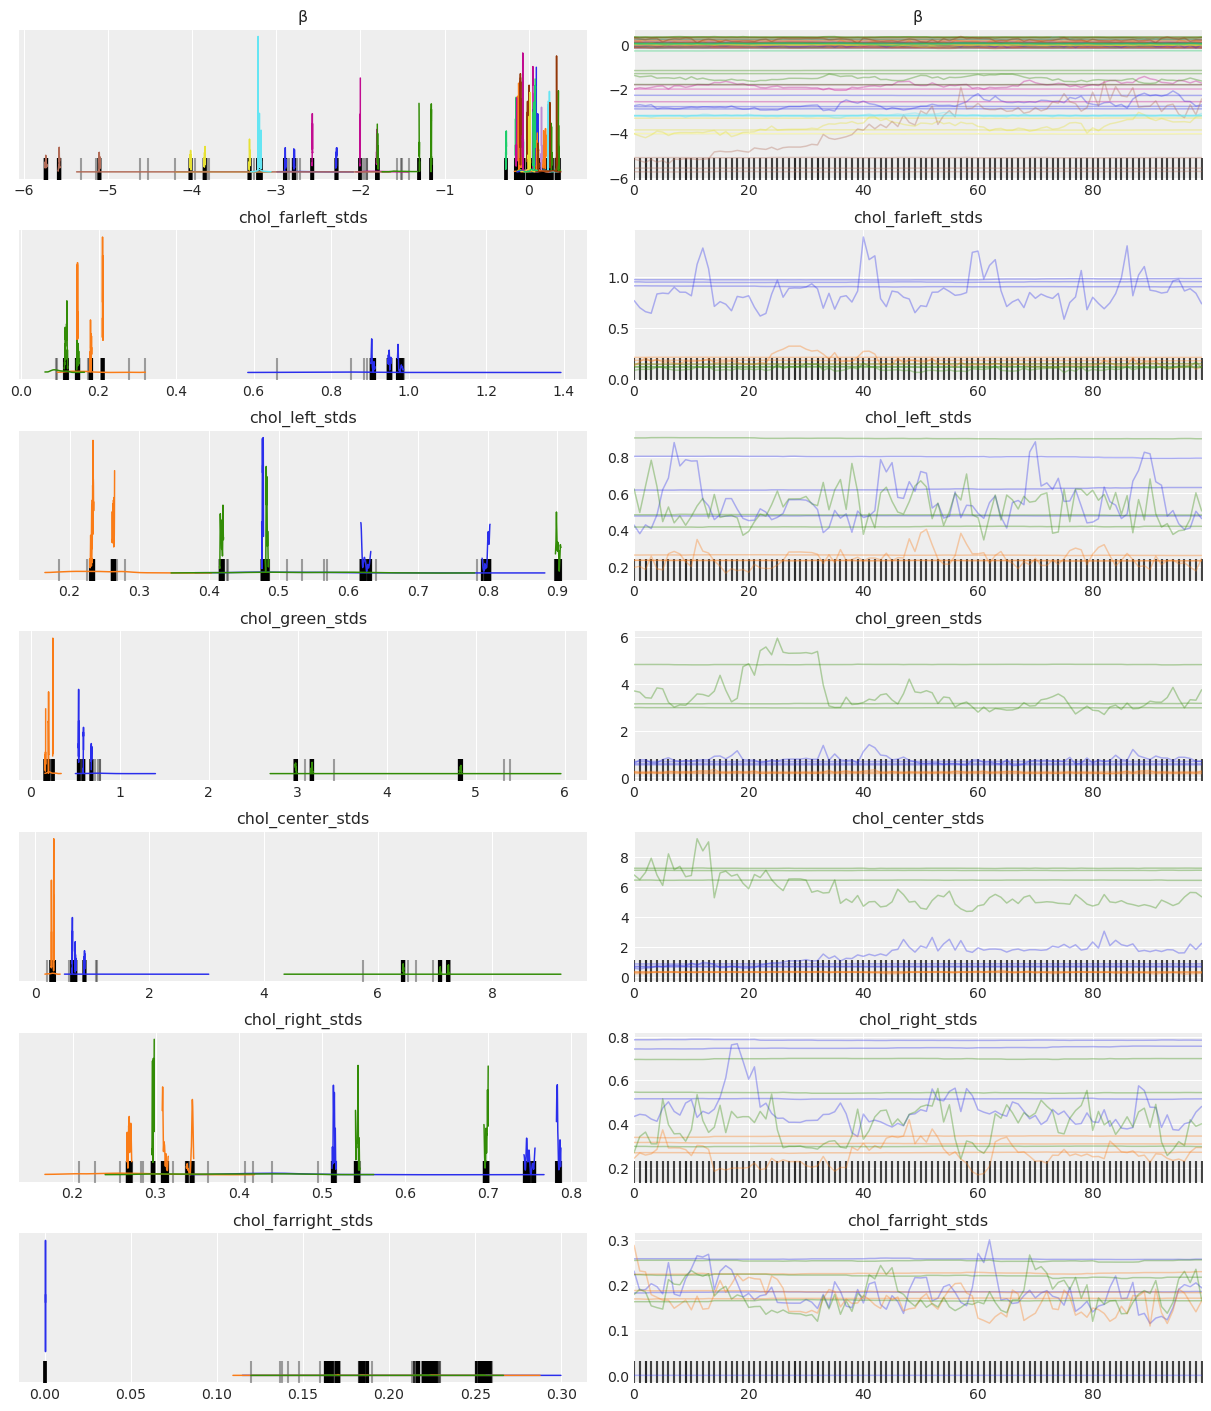

In [104]:
az.plot_trace(trace_nc, var_names=["β$", r"_stds"], filter_vars="regex", compact=True, chain_prop={"ls": "-"});

In [105]:
az.summary(trace_nc, var_names=[r"_corr"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
chol_farleft_corr[0,0]   1.000  0.000   1.000    1.000      0.000    0.000   
chol_farleft_corr[0,1]   0.203  0.100  -0.017    0.308      0.029    0.021   
chol_farleft_corr[0,2]  -0.803  0.053  -0.919   -0.745      0.018    0.013   
chol_farleft_corr[1,0]   0.203  0.100  -0.017    0.308      0.029    0.021   
chol_farleft_corr[1,1]   1.000  0.000   1.000    1.000      0.000    0.000   
chol_farleft_corr[1,2]   0.028  0.123  -0.193    0.245      0.038    0.028   
chol_farleft_corr[2,0]  -0.803  0.053  -0.919   -0.745      0.018    0.013   
chol_farleft_corr[2,1]   0.028  0.123  -0.193    0.245      0.038    0.028   
chol_farleft_corr[2,2]   1.000  0.000   1.000    1.000      0.000    0.000   
chol_left_corr[0,0]      1.000  0.000   1.000    1.000      0.000    0.000   
chol_left_corr[0,1]     -0.326  0.206  -0.626   -0.073      0.089    0.071   
chol_left_corr[0,2]     -0.026  0.375  -0.320    0.605      0.175    0.132   
chol_left_corr[1,0]     -0.326  0.206  -0.626   -0.073      0.089    0.071   
chol_left_corr[1,1]      1.000  0.000   1.000    1.000      0.000    0.000   
chol_left_corr[1,2]     -0.286  0.308  -0.768    0.166      0.144    0.109   
chol_left_corr[2,0]     -0.026  0.375  -0.320    0.605      0.175    0.132   
chol_left_corr[2,1]     -0.286  0.308  -0.768    0.166      0.144    0.109   
chol_left_corr[2,2]      1.000  0.000   1.000    1.000      0.000    0.000   
chol_green_corr[0,0]     1.000  0.000   1.000    1.000      0.000    0.000   
chol_green_corr[0,1]    -0.066  0.250  -0.426    0.239      0.110    0.083   
chol_green_corr[0,2]    -0.070  0.329  -0.536    0.284      0.148    0.112   
chol_green_corr[1,0]    -0.066  0.250  -0.426    0.239      0.110    0.083   
chol_green_corr[1,1]     1.000  0.000   1.000    1.000      0.000    0.000   
chol_green_corr[1,2]    -0.188  0.333  -0.611    0.270      0.155    0.117   
chol_green_corr[2,0]    -0.070  0.329  -0.536    0.284      0.148    0.112   
chol_green_corr[2,1]    -0.188  0.333  -0.611    0.270      0.155    0.117   
chol_green_corr[2,2]     1.000  0.000   1.000    1.000      0.000    0.000   
chol_center_corr[0,0]    1.000  0.000   1.000    1.000      0.000    0.000   
chol_center_corr[0,1]   -0.447  0.274  -0.696    0.124      0.123    0.096   
chol_center_corr[0,2]    0.055  0.459  -0.979    0.577      0.217    0.164   
chol_center_corr[1,0]   -0.447  0.274  -0.696    0.124      0.123    0.096   
chol_center_corr[1,1]    1.000  0.000   1.000    1.000      0.000    0.000   
chol_center_corr[1,2]   -0.533  0.134  -0.646   -0.224      0.055    0.043   
chol_center_corr[2,0]    0.055  0.459  -0.979    0.577      0.217    0.164   
chol_center_corr[2,1]   -0.533  0.134  -0.646   -0.224      0.055    0.043   
chol_center_corr[2,2]    1.000  0.000   1.000    1.000      0.000    0.000   
chol_right_corr[0,0]     1.000  0.000   1.000    1.000      0.000    0.000   
chol_right_corr[0,1]    -0.319  0.102  -0.547   -0.121      0.016    0.011   
chol_right_corr[0,2]    -0.276  0.468  -0.718    0.427      0.219    0.166   
chol_right_corr[1,0]    -0.319  0.102  -0.547   -0.121      0.016    0.011   
chol_right_corr[1,1]     1.000  0.000   1.000    1.000      0.000    0.000   
chol_right_corr[1,2]    -0.296  0.218  -0.726   -0.075      0.101    0.076   
chol_right_corr[2,0]    -0.276  0.468  -0.718    0.427      0.219    0.166   
chol_right_corr[2,1]    -0.296  0.218  -0.726   -0.075      0.101    0.076   
chol_right_corr[2,2]     1.000  0.000   1.000    1.000      0.000    0.000   
chol_farright_corr[0,0]  1.000  0.000   1.000    1.000      0.000    0.000   
chol_farright_corr[0,1] -0.152  0.173  -0.386    0.070      0.072    0.058   
chol_farright_corr[0,2] -0.195  0.626  -0.733    0.882      0.299    0.227   
chol_farright_corr[1,0] -0.152  0.173  -0.386    0.070      0.072    0.058   
chol_farright_corr[1,1]  1.000  0.000   1.000    1.000      0.000    0.000   
chol_farright_corr[1,2]  0.126  0.317  -0.227   

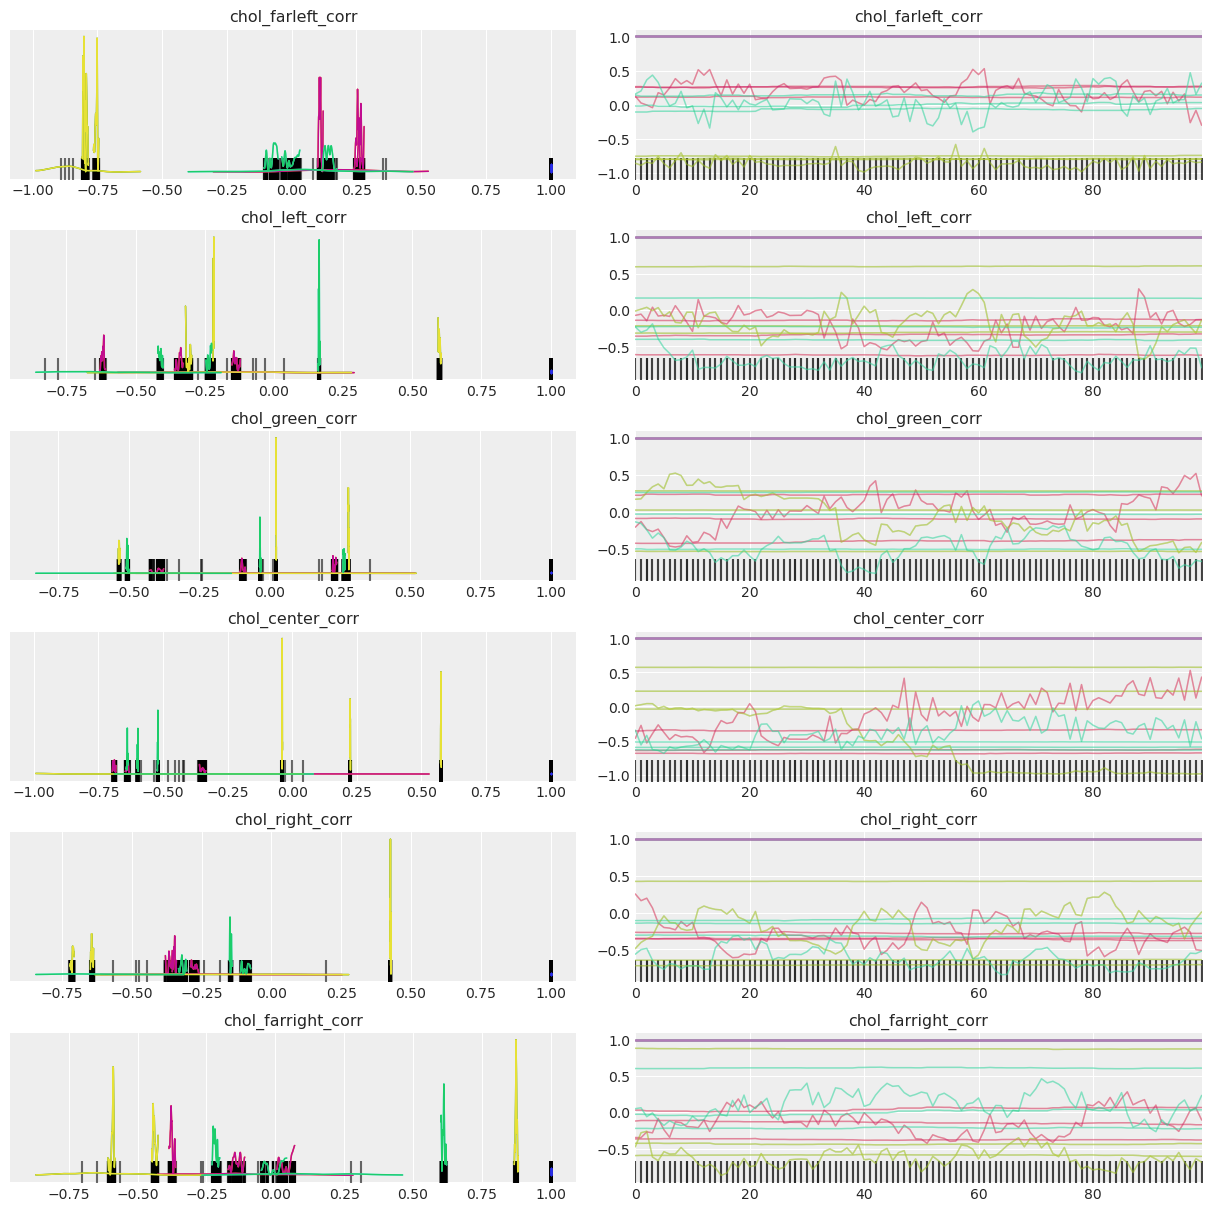

In [106]:
az.plot_trace(trace_nc, var_names=[r"_corr"], filter_vars="regex", compact=True, chain_prop={"ls": "-"});

In [20]:
with pm.Model(coords=COORDS) as m_prod:
    mus_parties = []
    log_unemployment = pm.Data("log_unemployment", stdz(np.log(d.unemployment)).values, dims="obs_id")
    stdz_polls = pm.Data("stdz_polls", stdz(d[PARTIES_AGG]).values, dims=("obs_id", "party")) # stdz(d[p]).values
    
    for p_id, p in enumerate(PARTIES_AGG):
        party = p.split("_")[0]
        if p in ["left_agg", "right_agg"]:
            # prior stddev in intercepts & slopes (variation across counties):
            sd_dist = pm.Exponential.dist(1.0)
            chol, _, _ = pm.LKJCholeskyCov(
                f"chol_{party}", eta=6, n=4, sd_dist=sd_dist, compute_corr=True
            )
            
            # average itc and slopes:
            β = pm.Normal(
                f"β_{party}",
                mu=np.array([-1.4, 0.0, 0.1, 0.0]),
                sd=np.array([0.5, 0.05, 0.05, 0.5]),
                dims="params_extend"
            )

            # population of varying effects:
            β_district = pm.MvNormal(
                f"β_district_{party}", mu=β, chol=chol, dims=("district", "params_extend")
            )
            
            # type-of-election offset:
            type_effect = pm.Normal(
                f"type_effect_{party}", mu=0.0, sigma=0.05, dims="election_type"
            )

            # expected value per district:
            if p == "right_agg":
                # linear model:
                mus_parties.append(
                    β_district[district_id, 0]
                    + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls[:, p_id]
                    + β_district[district_id, 3] * right_inc
                )
            else:
                mus_parties.append(
                    β_district[district_id, 0]
                    + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls[:, p_id]
                    + β_district[district_id, 3] * left_inc
                )

        else:
            sd_dist = pm.Exponential.dist(1.0)
            chol, _, _ = pm.LKJCholeskyCov(
                f"chol_{party}", eta=6, n=3, sd_dist=sd_dist, compute_corr=True
            )

            if p == "center_agg":
                β = pm.Normal(
                    f"β_{party}",
                    mu=np.array([-1.4, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    dims="params_short"
                )
            elif p in ["farleft_agg", "green_agg"]:
                β = pm.Normal(
                    f"β_{party}",
                    mu=np.array([-1.9, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    dims="params_short"
                )
            elif p == "farright_agg":
                β = pm.Normal(
                    f"β_{party}",
                    mu=np.array([-2.7, 0.0, 0.0]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    dims="params_short"
                )
            β_district = pm.MvNormal(
                f"β_district_{party}", mu=β, chol=chol, dims=("district", "params_short")
            )
            type_effect = pm.Normal(
                f"type_effect_{party}", mu=0.0, sigma=0.05, dims="election_type"
            )
            mus_parties.append(
                β_district[district_id, 0]
                + type_effect[type_id]
                + β_district[district_id, 1] * log_unemployment
                + β_district[district_id, 2] * stdz_polls[:, p_id]
            )

    mus_parties = tt.as_tensor_variable(mus_parties).T
    
    # account for polling errors, media narratives, “October surprises":
    noisy_mus = pm.Normal(
        "noisy_mus", mus_parties, 0.08, dims=("obs_id", "party")
    )
    
    # zero-inflation process:
    # push non-available parties towards -inf:
    noisy_mus = parties_available * noisy_mus
    
    # append last category:
    vary_pivot = pm.Normal("vary_pivot", mu=-3.0, sigma=0.05, dims="obs_id")
    noisy_mus = tt.horizontal_stack(noisy_mus, vary_pivot[:, None])
    
    # preferences of each district, for each election:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(noisy_mus), dims=("obs_id", "party_complete"))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs, dims="obs_id")

    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

(221, 7)
(221, 7)


Yeah, this is a big baby... And because of both the softmax inverse link and the hierarchical structure, we have to be very careful with our priors -- otherwise, our model won't run. The priors for each party are informed by scientific knowledge of each party's power in Paris. But they are on the logit scale (or... should we say softgit here?), as are all the other priors -- and all these parameters interact. 

So, the best way to make sense of our priors is to simulate samples from the prior predictive distribution, push them through the model and plot everything on the outcome scale (the probability of each party). As a matter of fact, I wrote such a function at the beginning of the notebook -- it's as if I read my own mind! `prior_pred_checks` will compute how probabilities evolve with the values of a predictor -- to see this impact the other predictors are held at zero. Remember that polls and unemployment are standardized, to a range from -3 to 4 should be more than enough to encompass their real values.

Now, what do our priors mean on the outcome scale?

In [21]:
prior_probs = prior_pred_checks(prior_checks, [-3.0, 4.0])

fig, axes = plt.subplots(2, 4, figsize=(17, 8), constrained_layout=True)
for i, ax in enumerate(axes.flat):
    try:
        for p in zip(prior_probs[-3.0][i], prior_probs[4.0][i]):
            ax.plot([-3, 4], p, color="k", alpha=0.2)
        if not i % 4:
            ax.set_xlabel("Std predictor -- others at 0")
        ax.set_ylabel(f"Probability of {PARTIES[i]}")
    except IndexError:
        continue

KeyError: 'β_district_p0'

Tada! There are still a lot of implausibly strong relationships, but these priors seem reasonable overall: strong enough to induce regularization of our parameters (they don't allow _crazy_ relationships impossible in reality) and weak enough to be moved by the data (of course data can be moving, you heartless monster!). And we see that some parties are _a priori_ stronger (left, center, right) than others, which shows we successfully incorporated prior knowledge into our model.

And now it's time for the climax of this notebook, for what you were looking for all these years, for the reason why you even started reading it: the sampling of the model (Beethoven's fifth symphony playing in the background)! Now that the model is compiled, it only takes one line of code with PyMC3. Before running this cell though, notice that the model takes some time to run -- it's a big and complex model after all! So, if you're not willing to wait for one hour, just trust my run of the model. But if you want to see the miracle of Hamiltonian Monte-Carlo happening before your eyes, then run the cell below!

While you're waiting, you can even go give the [PyMC](https://docs.pymc.io/) and [ArviZ](https://arviz-devs.github.io/arviz/) devs a warm thank you for their awesome work -- I'm sure they'll appreciate. Still got time? Go listen to some of these devs on [my podcast](https://learnbayesstats.anvil.app/), where I interview researchers and practitioners about Bayesian methods #ShamelessSelfPromotion.

In [110]:
with m_prod:
    trace_prod = pm.sample(
        2000, tune=1000, cores=8, chains=6, return_inferencedata=True,
        idata_kwargs={
            "dims": {
                "chol_farleft_stds": ["params_short"],
                 "chol_left_stds": ["params_extend"], 
                 "chol_green_stds": ["params_short"], 
                 "chol_center_stds": ["params_short"], 
                 "chol_right_stds": ["params_extend"],
                 "chol_farright_stds": ["params_short"],
                 "chol_farleft_corr": ["params_short", "params_short_bis"],
                 "chol_left_corr": ["params_extend", "params_extend_bis"],
                 "chol_green_corr": ["params_short", "params_short_bis"],
                 "chol_center_corr": ["params_short", "params_short_bis"],
                 "chol_right_corr": ["params_extend", "params_extend_bis"],
                 "chol_farright_corr": ["params_short", "params_short_bis"],
             }
         }
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [vary_pivot, noisy_mus, type_effect_p5, β_district_p5, β_p5, pchol_district_p5, type_effect_p4, β_district_p4, β_p4, pchol_district_p4, type_effect_p3, β_district_p3, β_p3, pchol_district_p3, type_effect_p2, β_district_p2, β_p2, pchol_district_p2, type_effect_p1, β_district_p1, β_p1, pchol_district_p1, type_effect_p0, β_district_p0, β_p0, pchol_district_p0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1361 seconds.


In [13]:
varnames = (
    [f"β_p{i}" for i in range(Nparties)]
    + [f"type_effect_p{i}" for i in range(Nparties)]
    + [f"sigma_district_p{i}" for i in range(Nparties)]
    + [f"Rho_district_p{i}" for i in range(Nparties)]
)
az.summary(trace_prod, var_names=varnames, round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
β_p0[0]            -2.75  0.19   -3.08    -2.38        0.0      0.0  10270.36   
β_p0[1]            -0.08  0.03   -0.14    -0.02        0.0      0.0   8547.23   
β_p0[2]             0.33  0.03    0.28     0.38        0.0      0.0   9546.84   
β_p1[0]            -1.71  0.17   -2.04    -1.40        0.0      0.0  10795.60   
β_p1[1]            -0.03  0.05   -0.12     0.05        0.0      0.0  12625.44   
...                  ...   ...     ...      ...        ...      ...       ...   
Rho_district_p4[4]  0.19  0.20   -0.19     0.55        0.0      0.0   8180.04   
Rho_district_p4[5] -0.43  0.24   -0.84     0.01        0.0      0.0  10288.94   
Rho_district_p5[0] -0.11  0.19   -0.46     0.25        0.0      0.0   7592.59   
Rho_district_p5[1] -0.54  0.16   -0.81    -0.24        0.0      0.0   8000.27   
Rho_district_p5[2]  0.08  0.20   -0.27     0.46        0.0      0.0   7248.34   

                      ess_sd  ess_bulk  ess_tail  r_hat  
β_p0[0]             10270.36  10970.27   6816.26    1.0  
β_p0[1]              8547.23   8728.23   6399.78    1.0  
β_p0[2]              9546.84  10335.13   6524.51    1.0  
β_p1[0]             10744.71  10919.47   7161.77    1.0  
β_p1[1]              6832.56  12599.28   6994.95    1.0  
...                      ...       ...       ...    ...  
Rho_district_p4[4]   8015.80   8194.32   7533.38    1.0  
Rho_district_p4[5]   9562.98  10266.61   6898.89    1.0  
Rho_district_p5[0]   5107.65   7555.70   5242.03    1.0  
Rho_district_p5[1]   8000.27   8447.44   6077.69    1.0  
Rho_district_p5[2]   5242.50   7182.16   6004.42    1.0  

[94 rows x 11 columns]

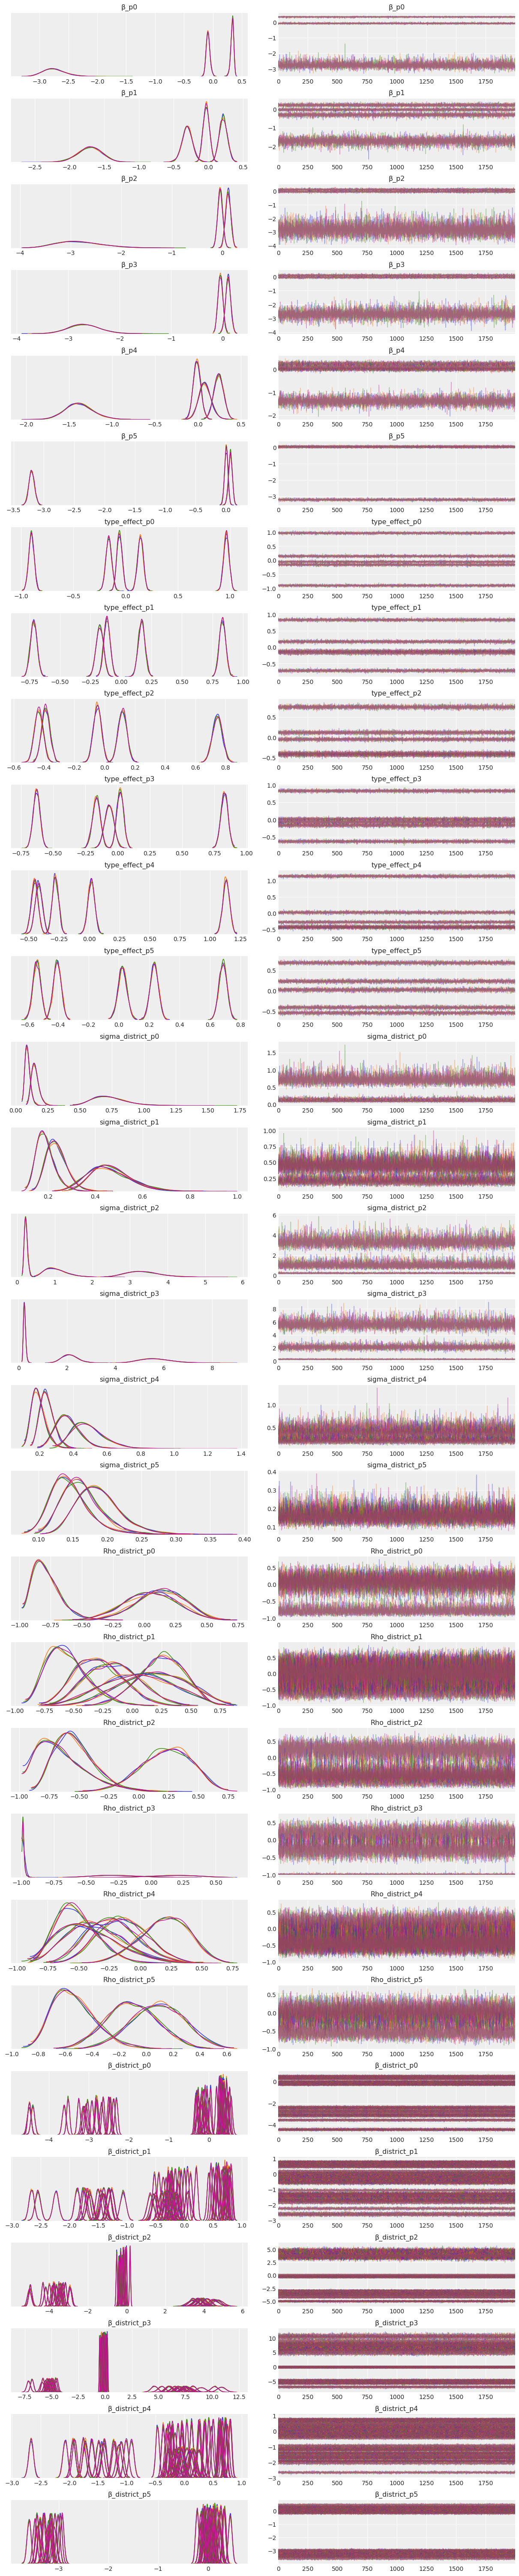

In [14]:
az.plot_trace(
    trace_prod,
    var_names=varnames + [f"β_district_p{i}" for i in range(Nparties)],
    compact=True,
);

Everything went smoothly: R-hats look good, the chains look good, the effective sample size look good, so all in all we're satisfied! I'm sure there are improvements to speep up sampling though, as one hour can be quite a long time. But I can live with that and I got a decent amount of samples.

To wrap up, let's save our samples for further analysis:

In [15]:
with open("trace_prod.pkl", "wb") as f:
    pickle.dump({"model": m_prod, "trace": trace_prod}, f)

Finally, let's do some posterior predictive checks: for any given election, how well does our model recover the true, observed proportions by parties. In other words, how well does our model "retrodict" the data, as Richard McElreath would say. I like this denomination because it emphasizes the fact that these are not _really_ predictions, as the model was trained on the elections we're now asking him about. 

It's as if we asked a student to recite his lesson by heart and then check how much she differed from what she knows are the true answers. A good result here can be a good sign -- but how well did she _understand_ what she learned? Can she transfer her knowledge to data and situations she never saw before? As good ol' Bill would say: _that_ is the question. And that's basically the role of out-of-sample predictions that we'll make in another notebook.

The code below compares, for each party, how far the model was from the true, observed proportions in each district. Each time the cell is executed, an election is chosen at random in the data used to fit the model.

In [16]:
with open("trace_prod.pkl", "rb") as f:
    data = pickle.load(f)

m_prod, trace_prod = data["model"], data["trace"]
idata = az.from_pymc3(trace_prod)
post = idata.posterior

share_est = trace_prod["p_district"]
share_mean = share_est.mean(0)

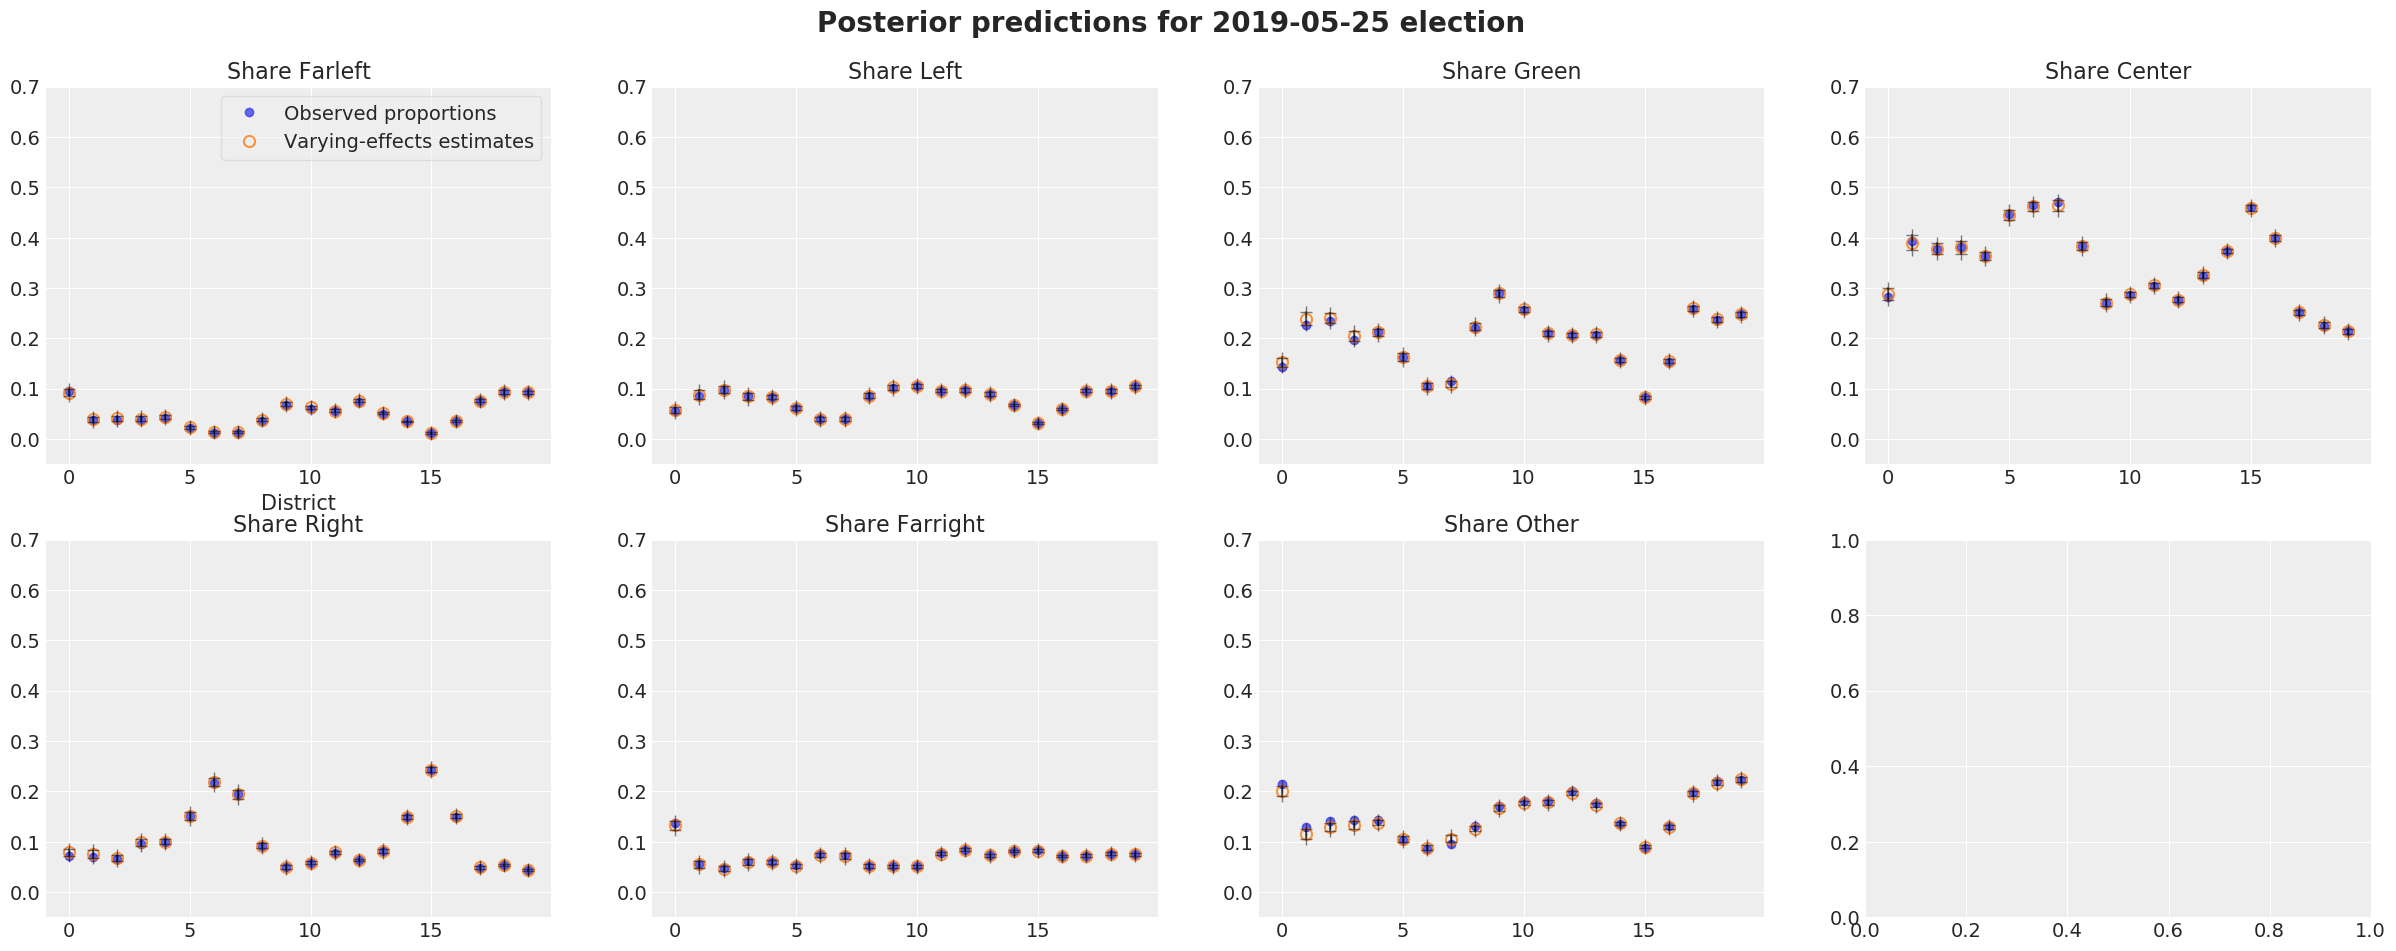

In [17]:
election = np.random.choice(d.date.unique(), replace=False)
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[election_mask, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, election_mask, i], credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.7])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    f"Posterior predictions for {np.datetime_as_string(election, unit='D')} election",
    y=0.95,
    size=20,
    weight="bold",
);

These retrodictions look good, very good -- to good to be true? Maybe; we'll how it goes for Paris 2020 city-council. That's also why it's so interesting to have a model running live during an election: you don't touch it anymore and you see where it succeeds... and where it fails. And those failures teach us about how to improve the model, which assumptions were wrong after all and how to update our beliefs about the true state of the world -- an eminently iterative and Bayesian process if you think about it #DropTheMic.

In addition to this overfitting risk though, I anticipate this model has other, more important weaknesses that I want to test and improve:

1. As I said at the beginning, it is time-ignorant, i.e it assumes that each party's latent support in the population is constant in time. I assert this is not true -- there more probably are trends of support that last more or less time and then give way to other trends. If true, this is a crucial feature of the true state of the world and the model should account fot it. For now, the hierarchical structure gives enough flexibility for the model to vary by district, party and type of election. But if, one day, an election coincide with a big shift in the underlying trends, I'm betting this type of model won't adjust for it fast enough.

2. Polls and, to a lesser extent, unemployment figures are arguably flawed with measurement errors. This is important information that the model ignores for now, and I'm pretty sure it tends to under-estimate uncertainty in the electoral process as a result. 

3. Another source of over-confidence in my opinion is the fact that the model ignores time remaining until election day. It shouldn't have the same level of confidence 60, 15 and 1 day before the election -- but right now it does.

So, there is definitely room for improvement! Granted, the uncertainty in the estimates also partly comes from the fact that the model lives in a simplex: all probabilities _must_ sum to one within each district. So, every district and every party are linked, which reduces the room for independent events -- once we learn that the left underperforms in its traditionally best districts, it becomes more probable that it did too in its least favorite districts. 

But if you discover other avenues of improvement or know how to solve one of the issues I layed out above, please feel free to reach out! Meanwhile, let's put this model to the test of real life. To be continued in the notebook `munic_model_analysis.ipynb`...

In [18]:
%watermark -a AlexAndorra -n -u -v -iv

pandas 0.25.3
arviz  0.6.1
pymc3  3.8
numpy  1.17.3
AlexAndorra 
last updated: Wed Mar 04 2020 

CPython 3.7.0
IPython 7.12.0
